## Setup



In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Turn off interactive mode, so we have full control
# over when our plots are displayed.
plt.ioff()

In [2]:
# The location of the saved figures
tmpdir = "/tmp/mpl"

In [3]:
%%bash -s "$tmpdir"

if [ -d "$1" ]
then 
    rm -rf "$1"
fi
mkdir "$1"

## Helper Functions

In [4]:
class FilenameGenerator(object):
    """A generator for creating unique filenames.
    """
    def __init__(self, basedir, ext):
        self.basedir = basedir
        self.ext = ext
        self.fignum = 0
    def __call__(self):
        self.fignum += 1
        return '%s/%d.%s' % (self.basedir, self.fignum, self.ext)
generate_filename = FilenameGenerator(tmpdir, 'png')

In [5]:
class PrintlnFunc(object):
    def __init__(self):
        self.line = 1
    def __call__(self, msg):
        print "%2d. %s" % (self.line, msg)
        self.line += 1
    def reset(self):
        self.line = 1
println = PrintlnFunc()

In [6]:
class Logger(object):
    """Wraps a function in a callable that prints call information
    """
    level = 0

    def __init__(self, fn):
        self.fn = fn

    def __call__(self, *args, **kwargs):
        # Create the padding string according to the current level in the call
        # stack, and increase the level since we're about to pop another 
        # function onto the stack.
        padding = "|" + "-" * (Logger.level * 4 - 1) if Logger.level > 0 else ""
        Logger.level += 1

        # Print calling information, call the function, and print returning info
        println("%sCalling %s.%s" % (padding, self.fn.__module__, self.fn.__name__))
        result = self.fn(*args, **kwargs)
        println("%sReturning <%s:%s> from %s.%s" % \
            (padding, result.__class__.__name__, id(result), self.fn.__module__, self.fn.__name__))

        # Decrease the call stack level, since we are returning.
        Logger.level -= 1
        return result

## Exploring the `pyplot` Call Stack

In [7]:
# Decorate several methods with the logger
plt.gca = Logger(plt.gca)
plt.gcf = Logger(plt.gcf)
plt.figure = Logger(plt.figure)
plt.close = Logger(plt.close)

# To decorate the methods on the Figure class, we have to wrap 
# our logger in a MethodType instance.
import types

# We're logging calls to the add_subplot method on the Figure
# class because this is where new Axes objects are created.
from matplotlib.figure import Figure
Figure.gca = types.MethodType(Logger(Figure.gca), None, Figure)
Figure.add_subplot = types.MethodType(Logger(Figure.add_subplot), None, Figure)

In [8]:
plt.get_fignums()

[]

In [9]:
plt.hist(np.random.randn(1000))
plt.savefig(generate_filename())

 1. Calling matplotlib.pyplot.gca
 2. |---Calling matplotlib.pyplot.gcf
 3. |-------Calling matplotlib.pyplot.figure
 4. |-------Returning <Figure:4368653200> from matplotlib.pyplot.figure
 5. |---Returning <Figure:4368653200> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4397103504> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4397103504> from matplotlib.figure.gca
10. Returning <AxesSubplot:4397103504> from matplotlib.pyplot.gca
11. Calling matplotlib.pyplot.gcf
12. Returning <Figure:4368653200> from matplotlib.pyplot.gcf


In [10]:
plt.get_fignums()

[1]

The interactive backends (UI and Jupyter notebook), the `_pylab_helpers.destroy` function is called once the figure is shown. So, we end up with only 1 active figure in the queue at all times. However, when rendering a hardcopy the figure is not destroyed, and so calling any plot command will simply add to the current figure. There are two ways to prevent this from happening: first, you can call the `plt.clf()` function to clear the current figure before you reuse it, second, you can call the `plt.figure()` function to create a new figure.

In [11]:
println.reset()
plt.clf()

 1. Calling matplotlib.pyplot.gcf
 2. Returning <Figure:4368653200> from matplotlib.pyplot.gcf


In [12]:
println.reset()
plt.plot(np.random.randn(100))
plt.savefig(generate_filename())

 1. Calling matplotlib.pyplot.gca
 2. |---Calling matplotlib.pyplot.gcf
 3. |---Returning <Figure:4368653200> from matplotlib.pyplot.gcf
 4. |---Calling matplotlib.figure.gca
 5. |-------Calling matplotlib.figure.add_subplot
 6. |-------Returning <AxesSubplot:4399496592> from matplotlib.figure.add_subplot
 7. |---Returning <AxesSubplot:4399496592> from matplotlib.figure.gca
 8. Returning <AxesSubplot:4399496592> from matplotlib.pyplot.gca
 9. Calling matplotlib.pyplot.gcf
10. Returning <Figure:4368653200> from matplotlib.pyplot.gcf


In [13]:
plt.get_fignums()

[1]

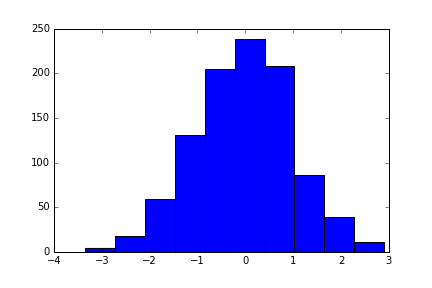

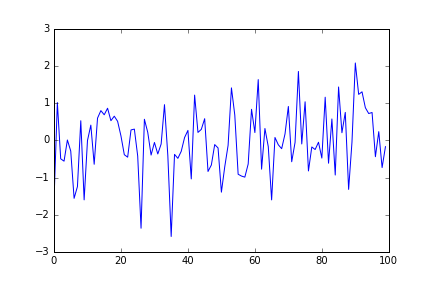

In [14]:
from IPython.display import Image, display_png
images = !ls /tmp/mpl/*.png
for img_fname in images:
    display_png(Image(filename=img_fname))